## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 5s 100us/step - loss: 2.4626 - accuracy: 0.0973 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.4626 - accuracy: 0.0997 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.7833 - accuracy: 0.6217 - val_loss: 3.1099 - val_accuracy: 0.5018
Epoch 47/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.7459 - accuracy: 0.6248 - val_loss: 2.9883 - val_accuracy: 0.5310
Epoch 48/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.7049 - accuracy: 0.6270 - val_loss: 2.9961 - val_accuracy: 0.5226
Epoch 49/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.6745 - accuracy: 0.6232 - val_loss: 2.9928 - val_accuracy: 0.5111
Epoch 50/50
50000/50000 [==============================] - 5s 101us/step - loss: 2.6329 - accuracy: 0.6324 - val_loss: 2.8840 - val_accuracy: 0.5374
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

Epoch 44/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9597 - accuracy: 0.6638 - val_loss: 1.3413 - val_accuracy: 0.5360
Epoch 45/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9465 - accuracy: 0.6689 - val_loss: 1.4306 - val_accuracy: 0.5191
Epoch 46/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.9355 - accuracy: 0.6715 - val_loss: 1.5003 - val_accuracy: 0.5022
Epoch 47/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.9216 - accuracy: 0.6766 - val_loss: 1.3498 - val_accuracy: 0.5310
Epoch 48/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.9082 - accuracy: 0.6806 - val_loss: 1.4417 - val_accuracy: 0.5135
Epoch 49/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.8965 - accuracy: 0.6861 - val_loss: 1.3851 - val_accuracy: 0.5345
Epoch 50/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.8858 - accuracy: 0.6899

50000/50000 [==============================] - 5s 102us/step - loss: 0.9814 - accuracy: 0.6528 - val_loss: 1.3684 - val_accuracy: 0.5298
Epoch 42/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.9681 - accuracy: 0.6570 - val_loss: 1.3481 - val_accuracy: 0.5320
Epoch 43/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.9570 - accuracy: 0.6631 - val_loss: 1.3525 - val_accuracy: 0.5284
Epoch 44/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.9455 - accuracy: 0.6659 - val_loss: 1.3581 - val_accuracy: 0.5287
Epoch 45/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.9329 - accuracy: 0.6717 - val_loss: 1.4106 - val_accuracy: 0.5207
Epoch 46/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.9257 - accuracy: 0.6728 - val_loss: 1.4115 - val_accuracy: 0.5193
Epoch 47/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9106 - accuracy: 0.6798 - val_loss:

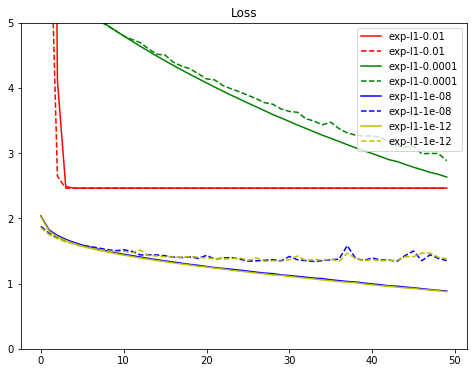

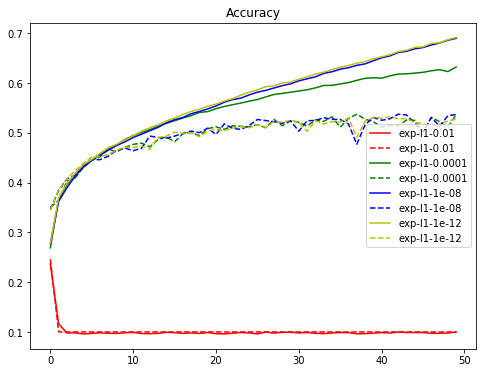

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [9]:
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 6s 111us/step - loss: 2.4615 - accuracy: 0.0971 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.4614 - accuracy: 0.0971 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 5s 108us/step - loss: 2.4614 - accuracy: 0.0998 - val_loss: 2.4614 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 5s 107us/step - loss: 1.7722 - accuracy: 0.4752 - val_loss: 1.7899 - val_accuracy: 0.4675
Epoch 46/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.7669 - accuracy: 0.4761 - val_loss: 1.8253 - val_accuracy: 0.4510
Epoch 47/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.7618 - accuracy: 0.4779 - val_loss: 1.7977 - val_accuracy: 0.4662
Epoch 48/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.7584 - accuracy: 0.4769 - val_loss: 1.7867 - val_accuracy: 0.4682
Epoch 49/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.7547 - accuracy: 0.4778 - val_loss: 1.7679 - val_accuracy: 0.4754
Epoch 50/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.7518 - accuracy: 0.4791 - val_loss: 1.8605 - val_accuracy: 0.4421
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

Epoch 43/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.6415 - accuracy: 0.5156 - val_loss: 1.6862 - val_accuracy: 0.4942
Epoch 44/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.6355 - accuracy: 0.5172 - val_loss: 1.6796 - val_accuracy: 0.4956
Epoch 45/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.6300 - accuracy: 0.5191 - val_loss: 1.6983 - val_accuracy: 0.4892
Epoch 46/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.6272 - accuracy: 0.5191 - val_loss: 1.6960 - val_accuracy: 0.4977
Epoch 47/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.6211 - accuracy: 0.5218 - val_loss: 1.6877 - val_accuracy: 0.4904
Epoch 48/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.6199 - accuracy: 0.5209 - val_loss: 1.6837 - val_accuracy: 0.4962
Epoch 49/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.6158 - accuracy: 0.5232

50000/50000 [==============================] - 5s 104us/step - loss: 1.6595 - accuracy: 0.5124 - val_loss: 1.7080 - val_accuracy: 0.4886
Epoch 41/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.6544 - accuracy: 0.5114 - val_loss: 1.8093 - val_accuracy: 0.4494
Epoch 42/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.6491 - accuracy: 0.5128 - val_loss: 1.7194 - val_accuracy: 0.4842
Epoch 43/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.6390 - accuracy: 0.5173 - val_loss: 1.6939 - val_accuracy: 0.4986
Epoch 44/50
50000/50000 [==============================] - 5s 104us/step - loss: 1.6362 - accuracy: 0.5163 - val_loss: 1.6872 - val_accuracy: 0.4918
Epoch 45/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.6312 - accuracy: 0.5161 - val_loss: 1.7264 - val_accuracy: 0.4688
Epoch 46/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.6292 - accuracy: 0.5185 - val_loss:

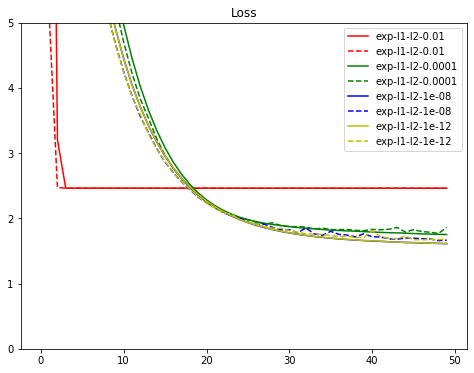

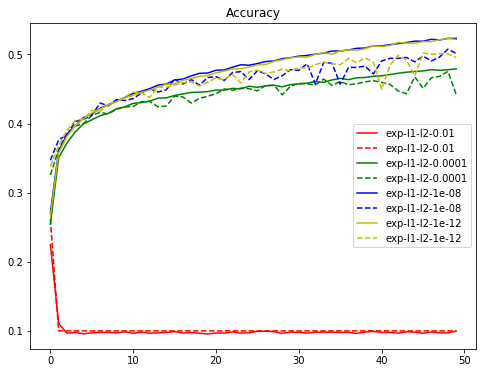

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()